## Farrow Structure Demonstration Program

This example:

 - Generates a simple sine wave is generated with a specified frequency and sampling rate.
 - Generates a set of Farrow Coefficients, for a linear interpolation fractional delay using a Farrow structure.
 - Applies the Farrow Filter to the sine wave to introduce a fractional delay

The flow diagram of the Farrow structure is shown in the following diagram:

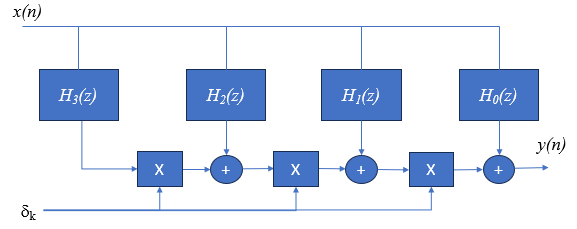

Copyright © 2026 Delta Numerix All rights reserved.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def generate_signal(frequency, sampling_rate, duration):
  t = np.arange(0, duration, 1 / sampling_rate)
  signal = np.sin(2 * np.pi * frequency * t)
  return t, signal


In [3]:
# Farrow structure coefficient design functions

def lagrange_filter_coeffs(filterLength, delay):
  filterCoefficients = [1.0] * filterLength
  for i in range(filterLength):
    for j in range(filterLength):
      if j != i:
        filterCoefficients[j] *= (delay - i) / (j - i)
  return filterCoefficients

def design_farrow_lagrange_coefficients(order, filterLength, delayTable):
  """
  Design coefficients for FIR filters in a Farrow structure.

  :param order: The order of the Farrow structure.
  :param filterLength: The length of the FIR filter.
  :param delayTable: Table of delays for each filter.
  :return: A matrix of coefficients for the Farrow structure.
  """
  # Initialize coefficient matrix
  farrow_coeffs = np.zeros((order + 1, filterLength))

  # Calculate coefficients for each polynomial term
  for n in range(order + 1):
    farrow_coeffs[n] = lagrange_filter_coeffs(filterLength, delayTable[n])

  return farrow_coeffs


In [4]:
# Farrow filter
def farrow_filter_apply(x, coeffs, delay):
  """
  Apply a Farrow fractional delay filter to an input signal.

  :param x: Input signal.
  :param coeffs: Polynomial coefficients for the Farrow structure.
  :param delay: Desired fractional delay (0 <= delay < 1).
  :return: Filtered signal with fractional delay applied.
  """
  N = len(coeffs)           # Number of filters - Farrow Order + 1
  y = np.zeros_like(x)      # Clear output array

  # Compute filtered output
  for n in range(N):
    d_shifted = delay ** n
    # Perform convolution for the current polynomial term
    y += d_shifted * np.convolve(x, coeffs[n, :], mode='full')[:len(x)]

  return y


In [5]:
# Parameters
order = 3               # Order of the Farrow structure
filter_length = 4       # Filter length
fs = 8000               # Sampling frequency
f = 1000                # Frequency of sinusoidal signal
useLagrangeFlag = False  # Set to True to use Lagrange to compute coefficients, otherwise use RBJ values

t, original_signal = generate_signal(f, fs, .0025)

# Design Farrow structure coefficients

if (useLagrangeFlag == True):
  delayTable = [1., 1.25, 1.5, 1.75]
  farrow_coeffs = design_farrow_lagrange_coefficients(3, 4, delayTable)

else:
  # RBJ: https://dsp.stackexchange.com/questions/93879/farrow-filter-effect-of-delta-delay/93890#93890
  farrow_coeffs = np.array([[     0.,     1.,     0.,     0., ],     # h0
                            [ -1./2.,     0.,  1./2.,     0., ],     # h1
                            [     1., -5./2.,     2., -1./2., ],     # h2
                            [ -1./2.,  3./2., -3./2.,  1./2., ]])    # h3

print("Farrow Structure Coefficients:")
print(farrow_coeffs)


Farrow Structure Coefficients:
[[0.00000 1.00000 0.00000 0.00000]
 [-0.50000 0.00000 0.50000 0.00000]
 [1.00000 -2.50000 2.00000 -0.50000]
 [-0.50000 1.50000 -1.50000 0.50000]]


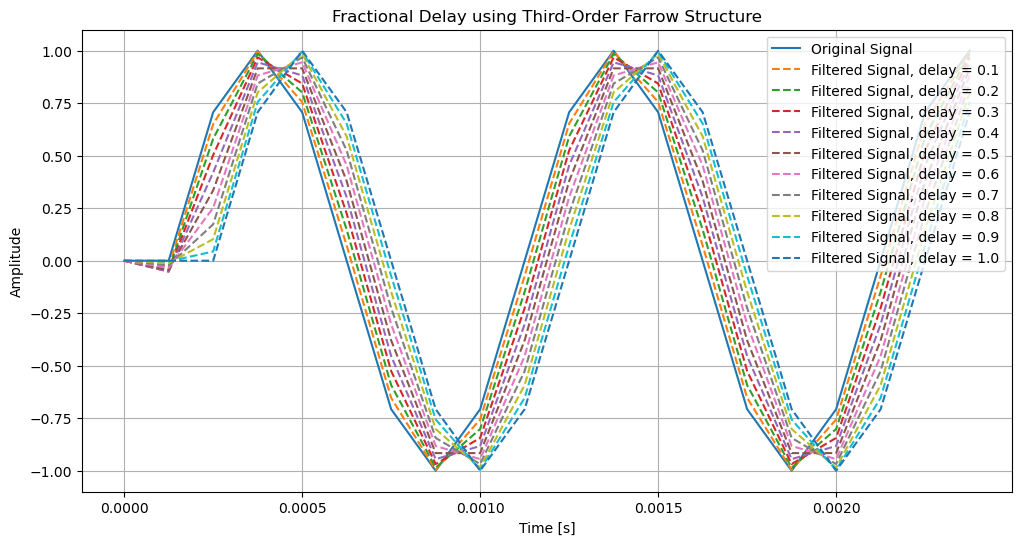

In [6]:
# Apply Farrow filter and plot results
plt.figure(figsize=(12, 6))

farrow_filter_base_delay = 1

plot_original = np.pad(original_signal, (farrow_filter_base_delay, 0))[:len(t)]    # Delay source to align with delay through Farrow structure
plt.plot(t, plot_original, label='Original Signal')

for delay in np.arange(.1, 1.1, .1):
  filtered_signal = farrow_filter_apply(original_signal, farrow_coeffs, delay)
  plt.plot(t, filtered_signal[:len(t)], label=f'Filtered Signal, delay = {delay:.2}', linestyle='--')

plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Fractional Delay using Third-Order Farrow Structure')
plt.legend(loc = 'upper right')
# plt.legend(loc = 'lower left')
plt.grid(True)

plt.show()


In [7]:
def compute_phase_response_unwrapped(signal, fftLength, fs):
  # Compute frequency response using FFT
  freq_response = np.fft.fft(signal, fftLength)

  # Calculate frequencies for the x-axis (normalized to the sample frequency)
  freqs = np.fft.fftfreq(len(freq_response), 1/fs)[:fftLength//2]

  # Calculate phase response
  phase_response = np.angle(freq_response[:fftLength//2])
  phase_response = np.unwrap(phase_response)

  return (freqs, phase_response)


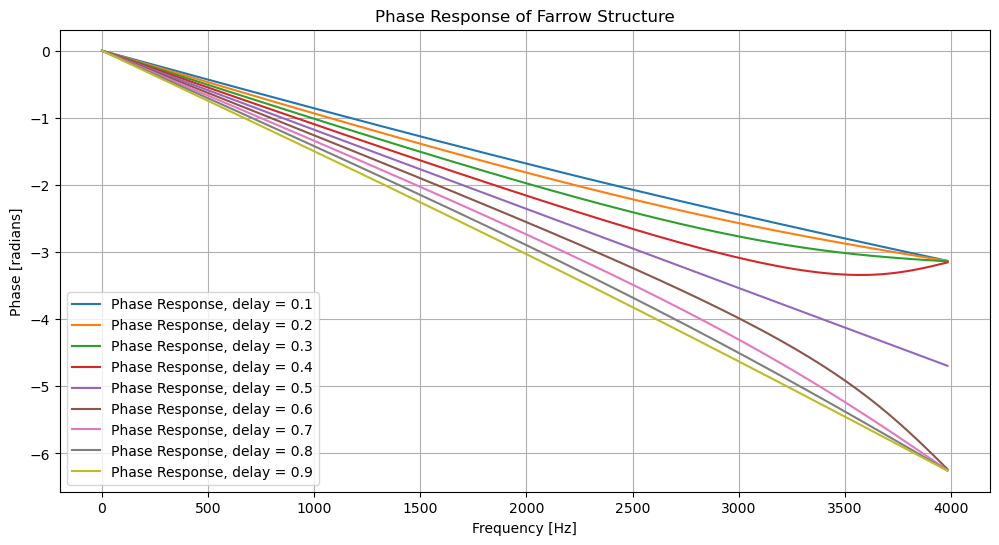

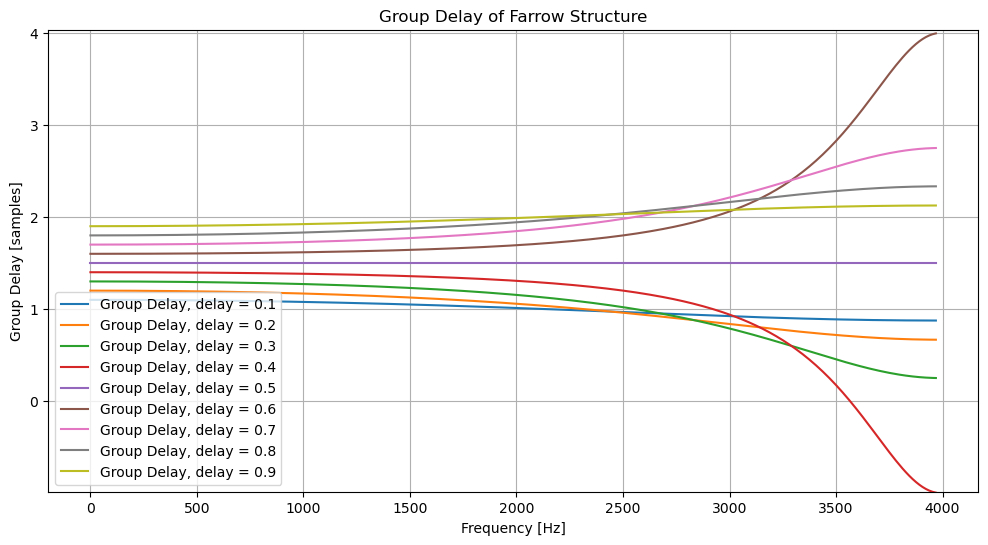

In [8]:
fftLength = 512

# Impulse response
impulse = np.zeros(fftLength)
impulse[0] = 1.0  # An impulse at the start

# Plot phase response
plt.figure(figsize=(12, 6))

for delay in np.arange(.1, 1.0, .1):
  filtered_signal = farrow_filter_apply(impulse, farrow_coeffs, delay)
  freqs, phase_response = compute_phase_response_unwrapped(filtered_signal, fftLength, fs)

  plt.plot(freqs, phase_response, label=f'Phase Response, delay = {delay:.2}')

plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [radians]')
plt.title('Phase Response of Farrow Structure')
# plt.legend(loc = 'upper right')
plt.legend(loc = 'lower left')
plt.grid(True)
plt.show()

# Plot group delay
plt.figure(figsize=(12, 6))
min = 1000
max = 0
for delay in np.arange(.1, 1.0, .1):
  filtered_signal = farrow_filter_apply(impulse, farrow_coeffs, delay)

  freqs, phase_response = compute_phase_response_unwrapped(filtered_signal, fftLength, fs)
  group_delay = -np.diff(phase_response) * (fs / (2. * np.pi)) / np.diff(freqs)
  plt.plot(freqs[:len(group_delay)], group_delay, label=f'Group Delay, delay = {delay:.2}')   # Note group delay calculation one sample shorter than source array length

  if (np.max(group_delay) > max):
    max = np.max(group_delay)
  if (np.min(group_delay) < min):
    min = np.min(group_delay)

plt.xlabel('Frequency [Hz]')
plt.ylabel('Group Delay [samples]')
plt.title('Group Delay of Farrow Structure')
# plt.legend(loc = 'upper right')
plt.legend(loc = 'lower left')
plt.grid(True)
plt.ylim([min*.99, max*1.01])
plt.show()
